In [1]:
# Importing base Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# Creating generators : used for data augmentation and provides better results
# With image generators we can create a batches of images with different shapes, rotations, positions etc...
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training generator
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255,
                                    validation_split = 0.2) # 20% of the training set will be used for validation

#test_data_gen = ImageDataGenerator(rescale=1./255) # We tried to create a testing generator but it failed to extract images from the corresponding file

In [3]:
# Dataset is zipped on the google drive so we import all the google drive on collab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# Unzipping the Dataset : mtd 1
import zipfile

local_zip = '/content/gdrive/MyDrive/Image-Classification-Transfer-Learning-master.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Images')
zip_ref.close()

# mtd 2
#!unzip '/content/sample_data/Image-Classification-Transfer-Learning-master.zip'

In [5]:
Batch_size = 8
img_h = 256
img_w = 256
num_classes=20
# Defining the classes to predict
classes = ['owl', # 0
            'galaxy', # 1
            'lightning', # 2
            'wine-bottle', # 3
            't-shirt', # 4
            'waterfall',# 5
            'sword', # 6
            'school-bus',# 7           
            'calculator', # 8
            'sheet-music', #9            
            'airplanes',#10      
            'lightbulb', # 11
            'skyscraper',#12    
            'mountain-bike',#13          
            'fireworks', #14        
            'computer-monitor',#15              
            'bear',# 16
            'grand-piano', # 17
            'kangaroo', # 18
            'laptop', #19
           ]

In [6]:
# Training set
SEED = 1234
tf.random.set_seed(SEED) 

training_dir = '/content/Images/Image-Classification-Transfer-Learning-master/Dataset/training'
test_dir = '/content/Images/Image-Classification-Transfer-Learning-master/Dataset/test'

train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               subset= 'training')  # targets are directly converted into one-hot vectors

# Validation set
valid_gen = train_data_gen.flow_from_directory(training_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size,
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED,
                                           subset= 'validation')

Found 1247 images belonging to 20 classes.
Found 307 images belonging to 20 classes.


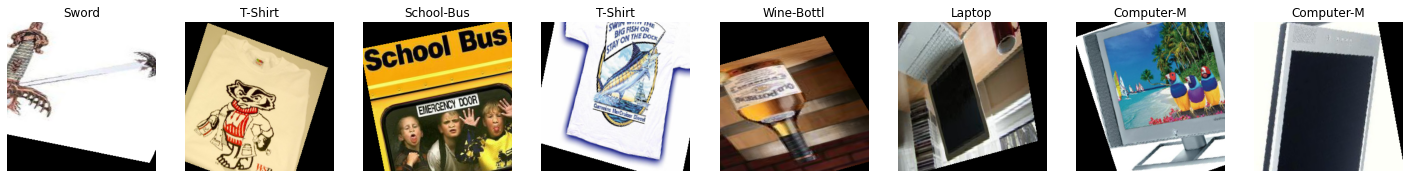

In [7]:
# Checking the classes 
CLASS_NAMES = np.array(['owl','galaxy', 'lightning','wine-bottle','t-shirt','waterfall', 'sword', 'school-bus',
                        'calculator','sheet-music','airplanes', 'lightbulb', 'skyscraper','mountain-bike','fireworks', 
                        'computer-monitor','bear','grand-piano','kangaroo','laptop',], dtype='<U10')

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

Transfert learning is the fact of combining the knowlage of two models into one 

In [8]:
# ResNet152V2 Model which is a pretrained model on image classification
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

234561536/234545216 [==============================] - 1s 0us/step


In [9]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

# Adding layers to the model
x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)

output  = Dense(units=20, activation='softmax')(x)
model = Model(ResNet_model.input, output)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
# Loss and optimizer for the neuronal network
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# callback and lrr to control the model in the training
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    restore_best_weights=True,
) 

callbacks = [lrr, callback]

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

transfer_learning_history = model.fit_generator(generator=train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=100, # 100 epochs
                   callbacks=callbacks # We used callbacks                 
                    
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
155/155 [==============================] - 56s 229ms/step - loss: 1.5769 - accuracy: 0.5860 - val_loss: 2.7915 - val_accuracy: 0.7303 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 32s 206ms/step - loss: 0.9648 - accuracy: 0.7611 - val_loss: 1.7719 - val_accuracy: 0.7072 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 34s 219ms/step - loss: 0.7861 - accuracy: 0.7926 - val_loss: 0.9933 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 31s 203ms/step - loss: 0.6850 - accuracy: 0.8241 - val_loss: 0.5675 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 32s 204ms/step - loss: 0.5389 - accuracy: 0.8604 - val_loss: 0.4823 - val_accuracy: 0.9046 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 31s 202ms/step - loss: 0.4557 - accuracy: 0.8701 - val_loss: 0.7484 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 7/100
155/155 [=========================

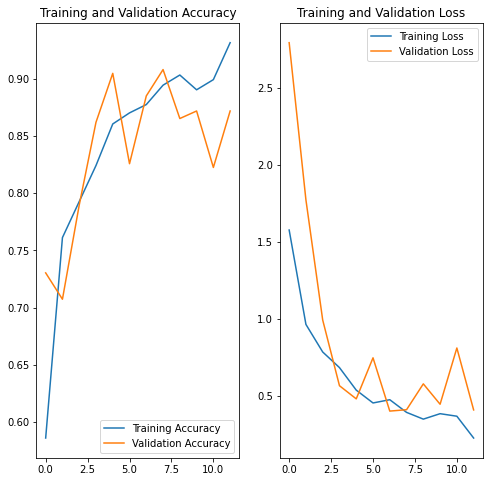

In [14]:
# plotting the loss and the accuracy during all epochs
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Creating list of the classes
class_names = train_gen.class_indices
print(list(class_names.keys()))

['owl', 'galaxy', 'lightning', 'wine-bottle', 't-shirt', 'waterfall', 'sword', 'school-bus', 'calculator', 'sheet-music', 'airplanes', 'lightbulb', 'skyscraper', 'mountain-bike', 'fireworks', 'computer-monitor', 'bear', 'grand-piano', 'kangaroo', 'laptop']


In [18]:
# Testing images per image from the testing set
class_names = train_gen.class_indices
print(class_names)
path = '/content/Images/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1117.jpg'

img = tf.keras.utils.load_img(
    path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.keras.layers.Rescaling(scale=1./255)(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch of images

prediction1 = model.predict(img_array)
score1 = tf.nn.softmax(prediction1[0])

# just a print of the corresponding result
print(
    "Model : This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(list(class_names.keys())[np.argmax(score1)], 100 * np.max(score1))
)

{'owl': 0, 'galaxy': 1, 'lightning': 2, 'wine-bottle': 3, 't-shirt': 4, 'waterfall': 5, 'sword': 6, 'school-bus': 7, 'calculator': 8, 'sheet-music': 9, 'airplanes': 10, 'lightbulb': 11, 'skyscraper': 12, 'mountain-bike': 13, 'fireworks': 14, 'computer-monitor': 15, 'bear': 16, 'grand-piano': 17, 'kangaroo': 18, 'laptop': 19}
Model : This image most likely belongs to airplanes with a 12.52 percent confidence.
